In [1]:
import numpy as np
import pyslm
import pyslm.visualise
import pyslm.geometry
import pyslm.analysis
from pyslm import hatching as hatching
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.collections as mc

In [2]:
scanRotation = 137.0 #in Degrees
nlayers=10 # no of layers
dx= 5e-3 # grid size in mm
bph=25 #baseplate height in grid points
layerThickness = 0.04 # [mm] # Set the layer thickness
hatchDistance=0.11 #mm
initialAngle =90 #degrees

In [3]:
# Imports the part and sets the geometry to  an STL file (frameGuide.stl)
solidPart = pyslm.Part('box')
solidPart.setGeometry('2pt5mm.STL')

solidPart.origin[0] = 0.0
solidPart.origin[1] = 0.0
solidPart.scaleFactor = 1.0
solidPart.rotation = [0, 0.0, 0.0]
solidPart.dropToPlatform()

In [4]:
# For plotting the generated hatches
def plothatch(layer):
    hatchGeoms = layer.getHatchGeometry()
    
    fig, ax = plt.subplots()
    
    hatchGeoms = layer.getHatchGeometry()

    if len(hatchGeoms) > 0:

        hatches = np.vstack([hatchGeom.coords.reshape(-1, 2, 2) for hatchGeom in hatchGeoms])

        lc = mc.LineCollection(hatches, color="red", linewidths=1.5)
            
        
        for hatch in hatches:
            midPoint = hatch[1, :] #np.mean(hatch, axis=0)
            delta = hatch[1, :] - hatch[0, :]

            ax.annotate('', xytext = midPoint - delta * 1e-4,xy = midPoint,
                        arrowprops={'arrowstyle': "->", 'facecolor': 'black','lw':2.0})
        ax.add_collection(lc)
        ax.axis('scaled')
        ax.set(xlim=(0, 2.5), ylim=(0, 2.5))
        ax.plot()

In [5]:
# Create a StripeHatcher object for performing any hatching operations
myHatcher = hatching.Hatcher()

# Set the base hatching parameters which are generated within Hatcher
myHatcher.hatchAngle = initialAngle
myHatcher.hatchDistance=hatchDistance
myHatcher.volumeOffsetHatch = 0.08
myHatcher.spotCompensation = 0.06
myHatcher.numInnerContours = 0
myHatcher.numOuterContours = 0
myHatcher.hatchSortMethod = hatching.AlternateSort()

#Perform the hatching operations
print('Hatching Started')

Hatching Started


In [6]:
x=[]
y=[]
z=[]
p=[]

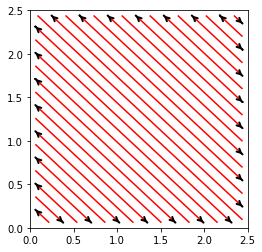

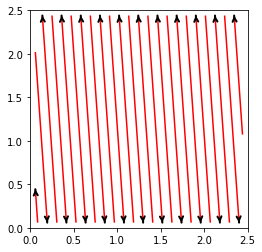

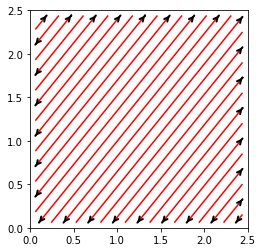

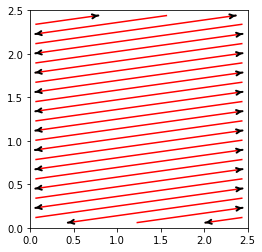

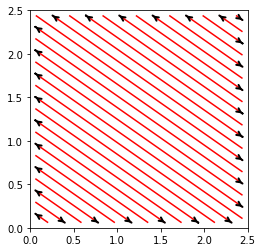

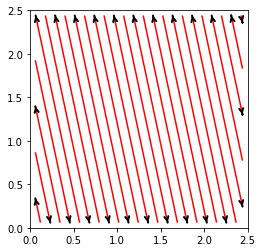

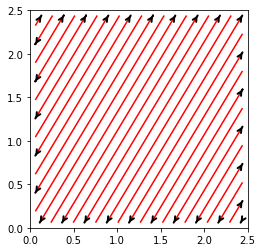

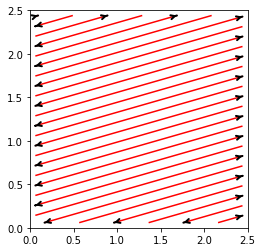

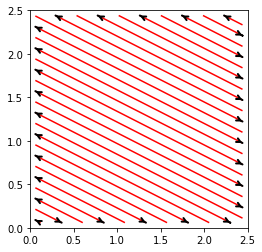

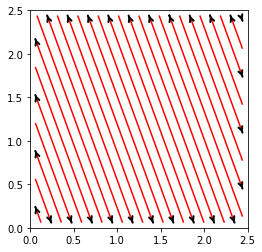

In [7]:
# Slice each layer, generate hatch, increment the angle and repeat the process
for i in range(1,nlayers+1):
    myHatcher.hatchAngle += scanRotation
    geomSlice = solidPart.getVectorSlice(i*layerThickness)
    layer = myHatcher.hatch(geomSlice)
    hatchGeoms = layer.getHatchGeometry()
    hatches = np.vstack([hatchGeom.coords.reshape(-1, 2, 2) for hatchGeom in hatchGeoms])
    a=hatches.shape[0]*hatches.shape[1]
    data=hatches.reshape(a,2)
    pauses=hatches.shape[0]*[0.0,2.0]
    pauses[-1]=1.0
    zdir=a*[i*layerThickness]
    plothatch(layer) # Comment this line to avoid hatching
    #sanity check
    if a== len(pauses) and a == len(zdir):        
        x.append(data[:,0])
        y.append(data[:,1])
        z.append(zdir)
        p.append(pauses)
    else:
        print("dimension mismatch",a,len(pauses),len(zdir))

In [8]:
xflat=[xd for xs in x for xd in xs]
yflat=[yd for ys in y for yd in ys]
pflat=[pd for ps in p for pd in ps]
zflat=[zd for zs in z for zd in zs]

In [9]:
df = pd.DataFrame(
    {'x': xflat,
     'y': yflat,
     'z': zflat,
     'dist':"",
     'pause':pflat
    })

In [10]:
#Non dimensionalize the coordinates
df['x']=round(df['x']/dx)
df['y']=round(df['y']/dx)
df['z']=bph+round(df['z']/dx)

In [11]:
df['dist']=""

In [12]:
df['dist'].iloc[0]=0.0

/home/hariharan/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
#  Calculate pause and distance travelled by laser - needed for SPPARKS
for i in range(1,len(df.index)):
    if df["pause"].iloc[i-1]>0.0:
        df["dist"].iloc[i]=df["dist"].iloc[i-1]
    else:
        df["dist"].iloc[i]=df["dist"].iloc[i-1]+np.sqrt(((df["x"].iloc[i]-df["x"].iloc[i-1])**2)+((df["y"].iloc[i]-df["y"].iloc[i-1])**2))

In [14]:
df

,x,y,z,dist,pause
0,44.0,12.0,33.0,0.0,0.0
1,12.0,42.0,33.0,43.863424,2.0
2,12.0,72.0,33.0,43.863424,0.0
3,76.0,12.0,33.0,131.590273,2.0
4,108.0,12.0,33.0,131.590273,0.0
...,...,...,...,...,...
549,488.0,347.0,105.0,102973.343266,2.0
550,488.0,412.0,105.0,102973.343266,0.0
551,460.0,488.0,105.0,103054.337093,2.0
552,484.0,488.0,105.0,103054.337093,0.0


In [15]:
df.to_csv('pathfile',index=False,header=False)

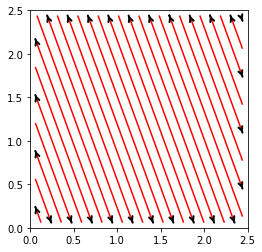

In [16]:
#Plot last layer
plothatch(layer)